# NN2
Tymoteusz Urban

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import copy

C:\Users\tymek\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\tymek\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [126]:
class NeuralNetwork:
    
    """
    Implementation of multi layer perceptron

    Attributes
    -----------
    layers : List
    
    """
    
    def __init__(self, layers, weights=None, biases=None, activations=None, initalization='xavier'):
        """
        activations - available functions: 'sigmoid', 'linear'
        initialization - available types: 'xavier', 'he', 'uniform'
        """
        self.layers = layers
        self.num_layers = len(layers)
        
        if weights is None:
            self.weights = [self.xavier_init(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [self.xavier_bias_init(layers[i]) for i in range(1, self.num_layers)]
        else:
            self.biases = biases
        
        if activations is None:
            self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['linear']
        else:
            self.activations = activations
        
        activation_functions = {
            'sigmoid': self._sigmoid,
            'linear': self._linear
        }
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), self.activations))
        
        self.mean = None
        self.std = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _linear(self, z):
        return z
    
    def xavier_init(self, n_in, n_out):
        variance = 2.0 / (n_in + n_out)
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
    
    def xavier_bias_init(self, n_out):
        variance = 1.0 / n_out
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, n_out)
    
    def feedforward(self, a, return_activations=False):
        if return_activations:
            activations = [a]
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
                activations.append(a)
            return activations
        else:
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
            return a
            
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict(self, X):
        return self.feedforward(X)
    
    def mse(self, X, y, resize=False, denormalize=None):
        """denormalize - a tuple (mean, std)"""
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
        predictions = self.predict(X)
        if denormalize:
            predictions = destandardize_data(predictions, denormalize)
        return np.mean((predictions - y) ** 2)
    
    def sigmoid_derivative(self, a):
        """calculates sigm'(z) where a = sigm(z)"""
        return a * (1-a)
    
    def backward(self, X, y, learning_rate):
        """backpropagation, returns partial derevatives"""
        # feedforward
        activations = self.feedforward(X, return_activations=True)
        deltas = [None] * len(self.weights)
        # output error
        deltas[-1] = activations[-1] - y.reshape(-1, 1)
        # calculate neurons' errors using backpropagation 
        for i in reversed(range(len(deltas) - 1)):
            if self.activations[i] == "sigmoid":
                # calculate error delta_l = delta_{l+1} x w_{l+1} * sigmoid'(a_{l+1})
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            elif self.activations[i] == "linear":
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T)
        
        L = len(self.weights)
        weights_gradient = [None] * L
        biases_gradient = [None] * L
        # calculate partial derevatives of cost function
        for i in range(L):
            # activations array is longer (so activations[l] in reality is a_{l-1})
            # weights_gradient[i] = np.sum('ij,jk->ijk', activations[i].T, deltas[i]) # to samo, ale dot 10x razy szybszy
            weights_gradient[i] = np.dot(activations[i].T, deltas[i])
            biases_gradient[i] = np.sum(deltas[i], axis=0)
            
        return weights_gradient, biases_gradient
        
    def update_weights(self, X, y, learning_rate):
        """
        updates weights using gradient descent
        """
        m = len(X)
        weights_gradient, biases_gradient = self.backward(X, y, learning_rate)
        for i in range(len(self.weights)):
            self.weights[i] -= (learning_rate/m) * weights_gradient[i]
            self.biases[i] -= (learning_rate/m) * biases_gradient[i]
    
    def create_batches(self, X, y, batch_size):
        N = len(X)
        combined_data = np.array(list(zip(X, y)))
        np.random.shuffle(combined_data)

        X_shuffled = np.array(list(zip(*combined_data))[0])
        y_shuffled = np.array(list(zip(*combined_data))[1])

        X_mini_batches = [X_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        y_mini_batches = [y_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        return X_mini_batches, y_mini_batches
        
    def train(self, X, y, learning_rate=0.001, epochs=10000, batch_size=None, return_history=False,
              X_test=None, y_test=None, cutoff=None, resize=False, denormalize=None, info_interval=500):
        """
        To test and print MSE on testset, X_test and y_test need to be provided
        To set early stopping, provide cutoff (and test sets)
        denormalize - a tuple (mean, std) for denormalizing target
        info_interval - number of epochs between logging, set to None to turn off console output
        """
        test_mse = False
        if X_test is not None and y_test is not None:
            test_mse = True
        early_stopping = False
        if test_mse and cutoff is not None:
            early_stopping = True
        
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
            if test_mse:
                X_test = X_test.to_numpy().reshape(-1, 1)
                y_test = y_test.to_numpy().reshape(-1, 1)
            
        if batch_size is None:
            batch_size = len(X)
        
        y_mse = y
        if denormalize is not None:
            y_mse = destandardize_data(y, denormalize)
            
        history = []
        test_loss = 0
        
        for epoch in range(1, epochs+1):
            
            if batch_size < len(X):
                batches_x, batches_y = self.create_batches(X, y, batch_size)
                for i in range(len(batches_x)):
                    self.update_weights(batches_x[i], batches_y[i], learning_rate)
            else:
                self.update_weights(X, y, learning_rate)
            
            if info_interval is not None and epoch % info_interval == 0:
                loss = self.mse(X, y_mse, denormalize=denormalize)    
                training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                if test_mse:
                    loss_test = self.mse(X_test, y_test, denormalize=denormalize)
                    training_info += f" Test Loss = {round(loss_test, 3)}"
                print(training_info)

            history.append([copy.deepcopy(self.weights), copy.deepcopy(self.biases)])
            
            if early_stopping:
                loss_es = self.mse(X_test, y_test, denormalize=denormalize)
                if loss_es < cutoff:
                    loss = self.mse(X, y_mse, denormalize=denormalize)    
                    training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                    loss_test = self.mse(X_test, y_test, denormalize=denormalize)
                    training_info += f" Test Loss = {round(loss_test, 3)}"
                    print(training_info)
                    break
        
        if return_history:
            return history

def standardize_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

def destandardize_data(X, parameters):
    """parameters: a tuple (mean, std)"""
    return X * parameters[1] + parameters[0]

def plot_weights(history, layer, bias=False):
    """
    layer - integer, index of weights vector
    if to plot bias instead of weights 
    """
    weight_type = 0
    if bias:
        weight_type = 1
    weights = []
    for epoch in history:
        weights.append(epoch[weight_type][layer].flatten())

    weights = np.array(first_weights)

    for i in range(weights.shape[1]):
        w_y = weights[:,i]
        plt.plot(range(len(history)), w_y)
    plt.show()

In [3]:
square_simple = pd.read_csv("../dane/regression/square-simple-test.csv", index_col=0)
square_simple_train = pd.read_csv("../dane/regression/square-simple-training.csv", index_col=0)
steps_large = pd.read_csv("../dane/regression/steps-large-test.csv", index_col=0)

### Pierwszy zbior

In [7]:
mlp = NeuralNetwork([1,10,1])
y_norm, parameters = standardize_data(square_simple_train['y'])
history = mlp.train(square_simple_train['x'], y_norm, learning_rate=0.1, epochs=20000, return_history=True, resize=True,
                   X_test=square_simple['x'], y_test=square_simple['y'], cutoff=None, denormalize=parameters, info_interval=1000)

Epoch 1000: Loss = 1855.881 Test Loss = 1269.738
Epoch 2000: Loss = 150.949 Test Loss = 122.253
Epoch 3000: Loss = 66.933 Test Loss = 60.975
Epoch 4000: Loss = 38.235 Test Loss = 38.014
Epoch 5000: Loss = 24.131 Test Loss = 25.105
Epoch 6000: Loss = 16.0 Test Loss = 17.171
Epoch 7000: Loss = 11.029 Test Loss = 12.156
Epoch 8000: Loss = 7.898 Test Loss = 8.924
Epoch 9000: Loss = 5.885 Test Loss = 6.809
Epoch 10000: Loss = 4.572 Test Loss = 5.407
Epoch 11000: Loss = 3.703 Test Loss = 4.466
Epoch 12000: Loss = 3.119 Test Loss = 3.825
Epoch 13000: Loss = 2.721 Test Loss = 3.382
Epoch 14000: Loss = 2.444 Test Loss = 3.069
Epoch 15000: Loss = 2.246 Test Loss = 2.842
Epoch 16000: Loss = 2.101 Test Loss = 2.673
Epoch 17000: Loss = 1.992 Test Loss = 2.543
Epoch 18000: Loss = 1.906 Test Loss = 2.44
Epoch 19000: Loss = 1.836 Test Loss = 2.354
Epoch 20000: Loss = 1.777 Test Loss = 2.281


In [8]:
print("MSE:", mlp.mse(square_simple['x'], square_simple['y'], resize=True, denormalize=parameters))

MSE: 2.2807310899115008


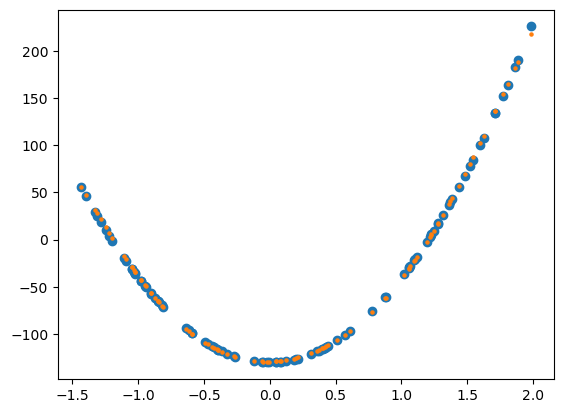

In [127]:
y_pred = mlp.predict(square_simple['x'].to_numpy().reshape(-1,1))
y_pred = destandardize_data(y_pred, parameters=parameters)
plt.scatter(square_simple['x'], square_simple['y'])
plt.scatter(square_simple['x'], y_pred, s=5)
plt.show()

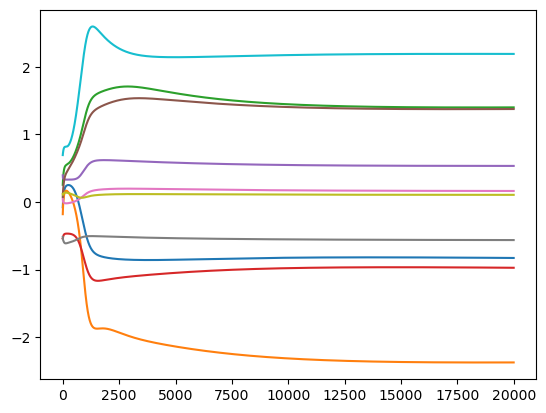

In [139]:
plot_weights(history, 0, bias=False)

### Eksperymenty

In [303]:
size = 100000
a = np.random.randn(size, 5)
d = np.random.randn(size, 10)
dot_times = []
einsum_times = []
einsum_dot_times = []

for i in range(20):
    
    start_time = time.time()
    np.dot(a.T,d) / size
    end_time = time.time()
    elapsed_time = end_time - start_time
    dot_times.append(elapsed_time)
    
    start_time = time.time()
    np.mean(np.einsum('ij, ik -> ijk', a, d), axis=0)
    end_time = time.time()
    elapsed_time = end_time - start_time
    einsum_times.append(elapsed_time)
    
    start_time = time.time()
    np.mean(np.einsum('ij, jk', a.T, d), axis=0)
    end_time = time.time()
    elapsed_time = end_time - start_time
    einsum_dot_times.append(elapsed_time)
    
print("Średni czas dot:", np.mean(dot_times) * 1000, "ms")
print("Średni czas einsum:", np.mean(einsum_times) * 1000, "ms")
print("Średni czas einsum_dot:", np.mean(einsum_dot_times) * 1000, "ms")

Średni czas dot: 1.9798874855041504 ms
Średni czas einsum: 17.966187000274658 ms
Średni czas einsum_dot: 3.65908145904541 ms


### Testowanie

In [255]:
a = np.random.randn(1000000, 2)
d = np.random.randn(1000000, 3)

In [237]:
suma = np.zeros((2,3))
# dla każdego x z batcha
for i in range(100):
    # biorę jego aktywacje
    col = a.T[:, i].reshape(-1,1)
    # biorę delty
    row = [d[i]]
    # wymnażam otrzymując macierz 2x3
    result = np.dot(col, row)
    suma += result
    # sumuję
np.round(suma)

array([[ 11.,   3.,   6.],
       [ -6.,  11., -27.]])

In [ ]:
# eksperyment, używać dot czy einsum
# wykres z czasem wykonywania operacji, dot 10 x szybszy

In [282]:
start_time = time.time()

np.sum(np.einsum('ij, ik -> ijk', a, d), axis=0) / 1000000

end_time = time.time()
elapsed_time = end_time - start_time
print("Czas operacji:", elapsed_time, "sekund")

Czas operacji: 0.04200315475463867 sekund


In [283]:
start_time = time.time()

np.mean(np.einsum('ij, ik -> ijk', a, d), axis=0)

end_time = time.time()
elapsed_time = end_time - start_time
print("Czas operacji:", elapsed_time, "sekund")

Czas operacji: 0.0664205551147461 sekund


In [305]:
df = pd.DataFrame()
df['x1'] = square_simple['x']
dfstd, _, _ = standardize_data(df)
dfstd['x2'] = square_simple['x']
dfstd

,x1,x2
1,-1.147359,-0.980437
2,-1.386513,-1.219074
3,-0.040289,0.124243
4,1.065644,1.227789
5,0.904856,1.067348
...,...,...
96,1.153421,1.315377
97,-1.364358,-1.196968
98,1.383307,1.544766
99,0.277204,0.441051
